In [5]:
import os

import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import networkx as nx

from utils.configure_results import configure_output_path, configure_result
from utils.ebcm import DirectedCMExamplePsi, DirectedEBCMParams, solve_directed_ebcm

from tqdm import tqdm

# グラフの色指定
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
markers = ["o", "^", "s", "D", "P", "X", "d", "H", "v", "p", "*"]
linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]

# グラフ全体のフォント設定
# plt.rcParams['font.family'] = 'serif'  # 全体のフォントをSerifに設定
# plt.rcParams['mathtext.fontset'] = 'cm'  # 数式のフォントをComputer Modernに設定
# plt.rcParams['mathtext.rm'] = 'serif'  # TeXの通常フォントをSerifに設定
# plt.rcParams['font.size'] = 18  # デフォルトフォントサイズ
# plt.rcParams['axes.labelsize'] = 18  # 軸ラベルのフォントサイズ
# plt.rcParams['axes.titlesize'] = 22  # タイトルのフォントサイズ
# plt.rcParams['legend.fontsize'] = 16  # 凡例のフォントサイズ
# plt.rcParams['grid.color'] = 'gray'  # グリッドの色を薄い灰色に設定
# plt.rcParams['grid.linestyle'] = ':'  # グリッドを点線に設定
# plt.rcParams['grid.linewidth'] = 0.5  # グリッドの線幅を設定

In [2]:
# 固定パラメータ
N = 100_000
k_hat = 5
batch_size = 16
threshold = 3
mu = 1.0
network_type_list = ["DirectedCMOutPow"]

In [3]:
all_results = {}
for network_type in network_type_list:
    output_path = configure_output_path(N, k_hat, threshold, network_type)
    print(f"output_path: {output_path}")

    result = configure_result(output_path, batch_size, True)
    all_results[network_type] = result
    print("--------------------------------")


output_path: /Users/black/directed-network-simulations/app/out/fastsar/DirectedCMOutPow/threshold=3/N=100000/khat=5
読み込んだファイル: ['results_00.csv', 'results_01.csv', 'results_02.csv', 'results_03.csv', 'results_04.csv', 'results_05.csv', 'results_06.csv', 'results_07.csv', 'results_08.csv', 'results_09.csv', 'results_10.csv', 'results_11.csv', 'results_12.csv', 'results_13.csv', 'results_14.csv', 'results_15.csv']


配列構築: 100%|██████████| 640/640 [00:04<00:00, 128.14it/s]

読み込んだ反復数: 640
lambdaDirected: 101個のユニークな値
lambdaNondirected: 3個のユニークな値
mu: 1個のユニークな値
値列: ['A', 'R', 'initialAdoptedTime', 'finalAdoptedTime']
--------------------------------


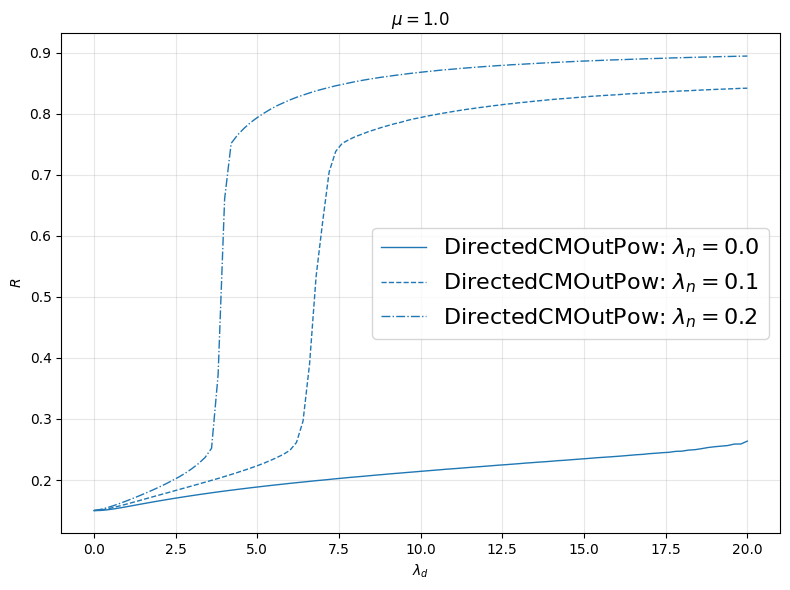

In [4]:
# グラフを描画
fig, ax = plt.subplots(figsize=(8, 6))

for nidx, network_type in enumerate(network_type_list):
    result = all_results[network_type]
    # 高次元配列とパラメータ値を取得
    R_array = result['arrays']['R']  # (itr, lambdaDirected, lambdaNondirected, mu)
    lambda_directed_values = result['param_values']['lambdaDirected']
    param_values = result['param_values']

    # パラメータのインデックスを取得（パラメータが1つの場合）
    mu_idx = 0
    lambda_nondirected_idx_list = [0, 1, 2]
    for lambda_nondirected_idx in lambda_nondirected_idx_list:
        # 各サンプル（各itr）ごとにプロット
        num_itr = R_array.shape[0]
        ax.plot(lambda_directed_values, R_array[:, :, lambda_nondirected_idx, mu_idx].mean(axis=0)/N, linewidth=1, linestyle=linestyles[lambda_nondirected_idx], color=colors[nidx], label=rf"{network_type}: $\lambda_n={param_values['lambdaNondirected'][lambda_nondirected_idx]}$")
        # ax.plot(lambda_directed_values, R_array[:, :, lambda_nondirected_idx, mu_idx].std(axis=0)/N, linewidth=1, color=colors[1])
        # ax.plot(lambda_directed_values, R_array[:, :, lambda_nondirected_idx, mu_idx].var(axis=0)/N, linewidth=1, color=colors[2])

ax.set_xlabel(r'$\lambda_d$')
ax.set_ylabel(r'$R$')
ax.set_title(rf"$\mu={param_values['mu'][mu_idx]}$")
ax.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

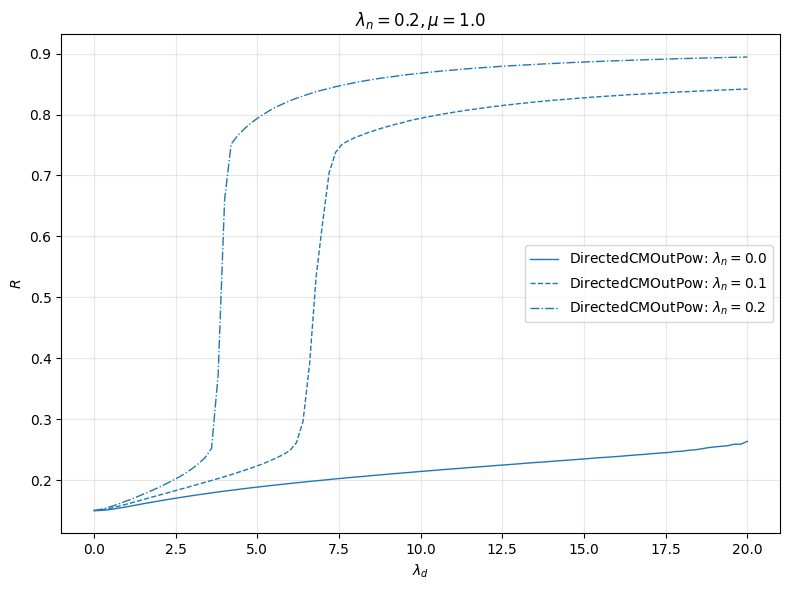

In [5]:

# グラフを描画
fig, ax = plt.subplots(figsize=(8, 6))

for n_idx, network_type in enumerate(network_type_list):
    result = all_results[network_type]
    R_array = result['arrays']['R']  # (itr, lambdaDirected, lambdaNondirected, mu)
    lambda_directed_values = result['param_values']['lambdaDirected']
    param_values = result['param_values']

    R_array_valid = np.zeros((R_array.shape[1], R_array.shape[2], R_array.shape[3]))
    valid_threshold = 100
    for lambda_directed_idx in range(R_array.shape[1]):
        for lambda_nondirected_idx in range(R_array.shape[2]):
            for mu_idx in range(R_array.shape[3]):
                valid_count = 0
                for itr in range(R_array.shape[0]):
                    R = R_array[itr, lambda_directed_idx, lambda_nondirected_idx, mu_idx]
                    if R > valid_threshold:
                        R_array_valid[lambda_directed_idx, lambda_nondirected_idx, mu_idx] += R
                        valid_count += 1
                R_array_valid[lambda_directed_idx, lambda_nondirected_idx, mu_idx] = R_array_valid[lambda_directed_idx, lambda_nondirected_idx, mu_idx] / valid_count if valid_count > 0 else 0

    for lambda_nondirected_idx in lambda_nondirected_idx_list:
        ax.plot(lambda_directed_values, R_array_valid[:, lambda_nondirected_idx, mu_idx]/N, linewidth=1, linestyle=linestyles[lambda_nondirected_idx], color=colors[n_idx], label=rf"{network_type}: $\lambda_n={param_values['lambdaNondirected'][lambda_nondirected_idx]}$")

ax.set_xlabel(r'$\lambda_d$')
ax.set_ylabel(r'$R$')
ax.set_title(rf"$\lambda_n={param_values['lambdaNondirected'][lambda_nondirected_idx]}, \mu={param_values['mu'][mu_idx]}$")
ax.grid(True, alpha=0.3)

# ax.set_ylim(0, 0.005)
plt.legend()
plt.tight_layout()
plt.show()